<a href="https://colab.research.google.com/github/tanzeyl/data-science-assignments/blob/main/Amazon_Fine_Foods_Review_t_SNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Apply t-SNE to Amazon Fine Food Reviews Dataset after vectorizing it using:

1.   Bag of Words
2.   TF-IDF

1.   Average Word2vect
2.   TF-IDF Word2Vec






In [ ]:
#Importing importing important modules
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Building dataframe from the database
conn = sqlite3.connect("/content/drive/MyDrive/Colab Notebooks/database.sqlite")
filtered_data = pd.read_sql_query("SELECT * FROM Reviews WHERE Score != 3", conn)

In [ ]:
def partition(x):
  if x >= 3:
    return "Positive"
  return "Negative"

In [ ]:
actual_score = filtered_data["Score"]
pos_neg = actual_score.map(partition)
filtered_data["Score"] = pos_neg

In [ ]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
#Removing duplicates
filtered_data = filtered_data.drop_duplicates(subset = {"UserId", "ProfileName", "Time", "Text"}, keep = "first", inplace = False)

In [ ]:
filtered_data.shape

(364173, 10)

In [ ]:
final = filtered_data[filtered_data.HelpfulnessNumerator <= filtered_data.HelpfulnessDenominator]

In [ ]:
final.shape

(364171, 10)

# Text Pre-Processing

In [ ]:
#Removing URLs from the data
# for sentence in final["Text"].values:
#   sentence = re.sub(r"http\S+", "", sentence)

In [ ]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
#Removing all HTML tags from the text
# for sentence in final["Text"].values:
#   soup = BeautifulSoup(sentence, "lxml")
#   sentence = soup.get_text()

In [ ]:
#Removing message language
def decontracted(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
#Removing words that contain numbers
# for sentence in final["Text"].values:
#   sentence = re.sub("\S*\d\S*", "", sentence).strip()

#Removing special characters
# for sentence in final["Text"].values:
#   sentence = re.sub('[^A-Za-z0-9]+', ' ', sentence)

In [ ]:
# Converting into lowerase
# preprocessed_reviews = []
# for sentence in final["Text"].values:
#   sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stop)
#   preprocessed_reviews.append(sentence.strip())

In [ ]:
from tqdm import tqdm
stop = set(stopwords.words("english"))
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stop)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [01:57<00:00, 3092.10it/s]


# Bag of Words

In [ ]:
count_vect = CountVectorizer()
count_vect.fit(preprocessed_reviews)
print("Some feature's names: ", count_vect.get_feature_names()[:10])
print('='*50)
final_counts = count_vect.transform(preprocessed_reviews)
print("The shape of out text BOW vectorizer: ",final_counts.get_shape())
print("The number of unique words ", final_counts.get_shape()[1])

Some feature's names:  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaa', 'aaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaa']
The shape of out text BOW vectorizer:  (364171, 116754)
The number of unique words  116754


# Applying t-SNE on Bow

In [ ]:
model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(final_counts[:100000])

In [ ]:
tsne_data = np.vstack((tsne_data.T, final["Score"][:100000])).T
tsne_data.shape

(100000, 3)

In [ ]:
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension 1", "Dimension 2", "Label"))
tsne_df["Dimension 1"] = tsne_df["Dimension 1"].astype("float64")
tsne_df["Dimension 2"] = tsne_df["Dimension 2"].astype("float64")

for i in range(0, len(tsne_df)):
  if tsne_df["Label"][i] == "Positive":
    tsne_df["Label"][i] = 1
  else:
    tsne_df["Label"][i] = 2

tsne_df["Label"] = tsne_df["Label"].astype("float64")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


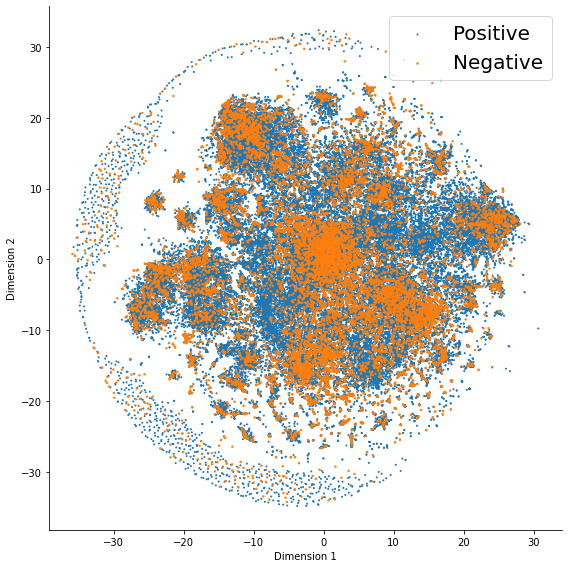

In [ ]:
sns.FacetGrid(tsne_df, hue="Label", height=8).map(plt.scatter, "Dimension 1", "Dimension 2", "Label")
L=plt. legend(prop = {"size" : 20})
L. get_texts()[0]. set_text("Positive")
L.get_texts()[1].set_text("Negative")

# Bi-grams and n-grams

In [ ]:
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("The type of count vectorizer: ",type(final_bigram_counts))
print("The shape of out text BOW vectorizer: ",final_bigram_counts.get_shape())
print("The number of unique words including both unigrams and bigrams: ", final_bigram_counts.get_shape()[1])

The type of count vectorizer:  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text BOW vectorizer:  (364171, 5000)
The number of unique words including both unigrams and bigrams:  5000


In [ ]:
model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(final_bigram_counts[:100000])

In [ ]:
tsne_data = np.vstack((tsne_data.T, final["Score"][:100000])).T
tsne_data.shape

(100000, 3)

In [ ]:
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension 1", "Dimension 2", "Label"))
tsne_df["Dimension 1"] = tsne_df["Dimension 1"].astype("float64")
tsne_df["Dimension 2"] = tsne_df["Dimension 2"].astype("float64")

for i in range(0, len(tsne_df)):
  if tsne_df["Label"][i] == "Positive":
    tsne_df["Label"][i] = 1
  else:
    tsne_df["Label"][i] = 2

tsne_df["Label"] = tsne_df["Label"].astype("float64")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


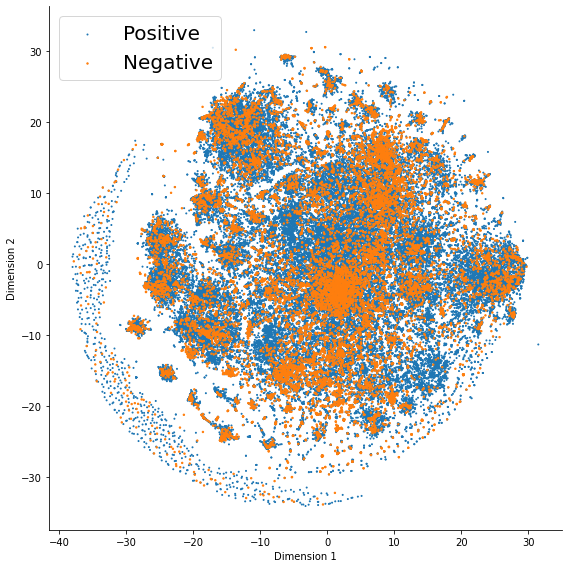

In [ ]:
sns.FacetGrid(tsne_df, hue="Label", height=8).map(plt.scatter, "Dimension 1", "Dimension 2", "Label")
L=plt. legend(prop = {"size" : 20})
L. get_texts()[0]. set_text("Positive")
L.get_texts()[1].set_text("Negative")

# TF-IDF

In [ ]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("Some sample features(unique words in the corpus): ",tf_idf_vect.get_feature_names()[0:10])
print('='*50)
final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("The type of count vectorizer: ",type(final_tf_idf))
print("The shape of out text TFIDF vectorizer: ",final_tf_idf.get_shape())
print("The number of unique words including both unigrams and bigrams: ", final_tf_idf.get_shape()[1])

Some sample features(unique words in the corpus):  ['aa', 'aaa', 'aaaaa', 'aaah', 'aafco', 'ab', 'aback', 'abandon', 'abandoned', 'abbey']
The type of count vectorizer:  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text TFIDF vectorizer:  (364171, 201787)
The number of unique words including both unigrams and bigrams:  201787


In [ ]:
model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(final_bigram_counts[:100000])

In [ ]:
tsne_data = np.vstack((tsne_data.T, final["Score"][:100000])).T
tsne_data.shape

(100000, 3)

In [ ]:
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension 1", "Dimension 2", "Label"))
tsne_df["Dimension 1"] = tsne_df["Dimension 1"].astype("float64")
tsne_df["Dimension 2"] = tsne_df["Dimension 2"].astype("float64")

for i in range(0, len(tsne_df)):
  if tsne_df["Label"][i] == "Positive":
    tsne_df["Label"][i] = 1
  else:
    tsne_df["Label"][i] = 2

tsne_df["Label"] = tsne_df["Label"].astype("float64")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


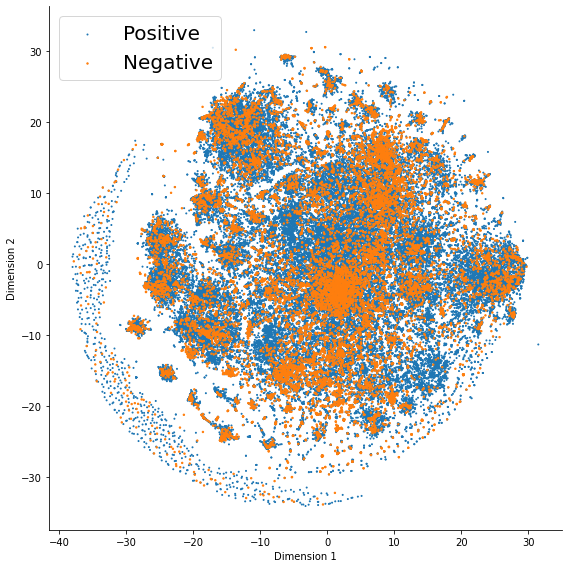

In [ ]:
sns.FacetGrid(tsne_df, hue="Label", height=8).map(plt.scatter, "Dimension 1", "Dimension 2", "Label")
L=plt. legend(prop = {"size" : 20})
L. get_texts()[0]. set_text("Positive")
L.get_texts()[1].set_text("Negative")

# Word2Vec

In [ ]:
#Training my own Word2Vec
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))

[('terrific', 0.8696532845497131), ('good', 0.8675072193145752), ('awesome', 0.8654647469520569), ('fantastic', 0.861689567565918), ('excellent', 0.8474671244621277), ('wonderful', 0.8031635880470276), ('perfect', 0.7970364689826965), ('nice', 0.7589874863624573), ('fabulous', 0.7527034282684326), ('amazing', 0.7126045227050781)]
[('nastiest', 0.8699419498443604), ('greatest', 0.7721356749534607), ('best', 0.7376850247383118), ('disgusting', 0.7306413054466248), ('terrible', 0.6961512565612793), ('horrid', 0.6955186128616333), ('horrible', 0.6726559996604919), ('tastiest', 0.6575813293457031), ('worse', 0.655315637588501), ('awful', 0.6548936367034912)]


In [ ]:
w2v_words = list(w2v_model.wv.vocab)
print("Number of words that occured minimum 5 times: ",len(w2v_words))
print("Sample words ", w2v_words[0:50])

Number of words that occured minimum 5 times:  33571
Sample words  ['bought', 'several', 'vitality', 'canned', 'dog', 'food', 'products', 'found', 'good', 'quality', 'product', 'looks', 'like', 'stew', 'processed', 'meat', 'smells', 'better', 'labrador', 'finicky', 'appreciates', 'arrived', 'labeled', 'jumbo', 'salted', 'peanuts', 'actually', 'small', 'sized', 'unsalted', 'sure', 'error', 'vendor', 'intended', 'represent', 'confection', 'around', 'centuries', 'light', 'pillowy', 'citrus', 'gelatin', 'nuts', 'case', 'filberts', 'cut', 'tiny', 'squares', 'liberally', 'coated']


# Average Word2Vec

In [ ]:
sent_vectors = [];
for sent in tqdm(list_of_sentance):
    sent_vec = np.zeros(50)
    cnt_words =0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 364171/364171 [17:10<00:00, 353.48it/s]

364171
50


In [ ]:
model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(sent_vectors[:100000])

In [ ]:
tsne_data = np.vstack((tsne_data.T, final["Score"][:100000])).T
tsne_data.shape

(100000, 3)

In [ ]:
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension 1", "Dimension 2", "Label"))
tsne_df["Dimension 1"] = tsne_df["Dimension 1"].astype("float64")
tsne_df["Dimension 2"] = tsne_df["Dimension 2"].astype("float64")

for i in range(0, len(tsne_df)):
  if tsne_df["Label"][i] == "Positive":
    tsne_df["Label"][i] = 1
  else:
    tsne_df["Label"][i] = 2

tsne_df["Label"] = tsne_df["Label"].astype("float64")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


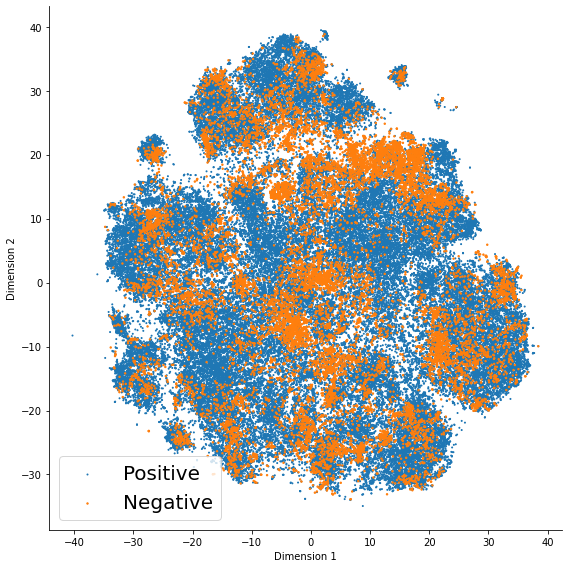

In [ ]:
sns.FacetGrid(tsne_df, hue="Label", height=8).map(plt.scatter, "Dimension 1", "Dimension 2", "Label")
L=plt. legend(prop = {"size" : 20})
L. get_texts()[0]. set_text("Positive")
L.get_texts()[1].set_text("Negative")

# TF-IDF Word2Vec

In [ ]:
model = TfidfVectorizer()
model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [ ]:
tfidf_feat = model.get_feature_names()
tfidf_sent_vectors = [];
row=0;
for sent in tqdm(list_of_sentance): 
    sent_vec = np.zeros(50) 
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

  4%|▎         | 12943/364171 [12:50<4:23:43, 22.20it/s]

In [ ]:
model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(final_bigram_counts[:100000])

In [ ]:
tsne_data = np.vstack((tsne_data.T, final["Score"][:100000])).T
tsne_data.shape

In [ ]:
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension 1", "Dimension 2", "Label"))
tsne_df["Dimension 1"] = tsne_df["Dimension 1"].astype("float64")
tsne_df["Dimension 2"] = tsne_df["Dimension 2"].astype("float64")

for i in range(0, len(tsne_df)):
  if tsne_df["Label"][i] == "Positive":
    tsne_df["Label"][i] = 1
  else:
    tsne_df["Label"][i] = 2

tsne_df["Label"] = tsne_df["Label"].astype("float64")

In [ ]:
sns.FacetGrid(tsne_df, hue="Label", height=8).map(plt.scatter, "Dimension 1", "Dimension 2", "Label")
L=plt. legend(prop = {"size" : 20})
L. get_texts()[0]. set_text("Positive")
L.get_texts()[1].set_text("Negative")